## Imports

In [4]:
import googlemaps
import pandas as pd
import numpy as np
import re
import os
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from pyproj import CRS
import math

## Imports

In [201]:
pd.set_option('display.max_columns',None)

## Links

Miami-Dade data download: https://gis-mdc.opendata.arcgis.com/datasets/MDC::property-boundary-view/about
DOR Use code descriptions: https://gis-mdc.opendata.arcgis.com/datasets/MDC::dor-code/explore

Palm Beach data download: https://opendata2-pbcgov.opendata.arcgis.com/datasets/PBCGOV::property-information-table/explore

Broward Property Appraiser "Contact Us" page: https://bcpa.net/phone.asp

## Data read-in

In [6]:
# Read in geographic data
MiamiDade_geo = gpd.read_file('miamidade_2022pin')
PalmBeach_geo = gpd.read_file('palmbeach_2022pin')
Broward_geo = gpd.read_file('broward_2022pin')

In [21]:
So_Fla_geo_list = [MiamiDade_geo,PalmBeach_geo,Broward_geo]

In [22]:
So_Fla_geo = gpd.GeoDataFrame(pd.concat(So_Fla_geo_list,ignore_index=True))

In [24]:
# Set the desired CRS
target_crs = CRS.from_epsg(4326)

# Change it to the desired crs
So_Fla = So_Fla_geo.to_crs(target_crs)
# MiamiDade = MiamiDade_geo.to_crs(target_crs)
# PalmBeach = PalmBeach_geo.to_crs(target_crs)
# Broward = Broward_geo.to_crs(target_crs)

In [12]:
# Load in Property Appraiser data
MiamiDade_data = gpd.read_file('NAL23F202201.dbf')
PalmBeach_data = gpd.read_file('NAL60F202201.dbf')
Broward_data = gpd.read_file('NAL16F202201.dbf')

In [ ]:
# Concat non geo dataframes
data_list = [MiamiDade_data,PalmBeach_data,Broward_data]

So_Fla_data = gpd.GeoDataFrame(pd.concat(data_list,ignore_index=True))

In [ ]:
# Drop the empty 'geometry' column
So_Fla_data = So_Fla_data.drop(columns='geometry')

In [27]:
# Convert the 'DOR_UC' code to type int
So_Fla_data['DOR_UC'] = So_Fla_data['DOR_UC'].astype(int)

In [30]:
# Whittle down the data to agricutlrual properties only
So_Fla_data_agri = So_Fla_data[(So_Fla_data['DOR_UC'] >= 50) & (So_Fla_data['DOR_UC'] <= 69)]

In [32]:
merged_So_Fla_agri = pd.merge(So_Fla_data_agri,So_Fla, left_on='PARCEL_ID', right_on='PARCELNO', how='inner')

In [35]:
columns_to_keep = ['PARCEL_ID','DOR_UC','PHY_ADDR1','PHY_CITY','geometry']

In [36]:
merged_So_Fla_agri_final = merged_So_Fla_agri[columns_to_keep]

In [235]:
merged_So_Fla_agri_final['PHY_ADDR1'] = merged_So_Fla_agri_final['PHY_ADDR1'].fillna('No Physical Address')

/var/folders/rq/0_j_rksd7psgdycg9c1qwf6m0000gp/T/ipykernel_2550/2304607047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_So_Fla_agri_final['PHY_ADDR1'] = merged_So_Fla_agri_final['PHY_ADDR1'].fillna('No Physical Address')


In [237]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_So_Fla_agri_final, geometry='geometry')

# Save the GeoDataFrame as a GeoJSON file
gdf.to_file('SoFla_agri_final.geojson', driver='GeoJSON')

## SoFla Other Restricted Properties

In [165]:
# Create zone descriptions
data = [
    {'DOR_UC':47,'DESC':'Mineral processing, phosphate processing, cement plants, refineries, clay plants, rock and gravel plants.'},
    {'DOR_UC':91,'DESC':'Utility, gas and electricity, telephone and telegraph, locally assessed railroads, water and sewer service, pipelines, canals, radio/television communication.'},
    {'DOR_UC':96,'DESC':'Sewage disposal, solid waste, borrow pits, drainage reservoirs, waste land, marsh, sand dunes, swamps.'},
    {'DOR_UC':49,'DESC':'Open storage, new and used building supplies, junk yards, auto wrecking, fuel storage, equipment and material storage.'},
    {'DOR_UC':20,'DESC':'Airports (private or commercial), bus terminals, marine terminals, piers, marinas.'}
       ]

DOR_desc_df = pd.DataFrame(data)

In [167]:
from shapely.ops import cascaded_union
from shapely.geometry import Polygon

In [210]:
So_Fla_geo['PARCEL_ID']

0          0101000000020
1          0101000000022
2          0101000000026
3          0101000000028
4          0101000000030
               ...      
2321071     514235030160
2321072     514235030170
2321073     514235030180
2321074     514235030190
2321075     514235030191
Name: PARCEL_ID, Length: 2321076, dtype: object

In [214]:
keep_list = [47, 91, 96, 49, 20, 81]
keep_list_airports = ['3031290000011','3079120000010','0821200000010','504222000311','00434431000001010','00434332000001090','00414201000005020']

In [215]:
So_Fla_geo_restricted = So_Fla_geo[(So_Fla_geo['DOR_UC'].isin(keep_list)) | (So_Fla_geo['PARCEL_ID'].isin(keep_list_airports))]

In [211]:
print(len(So_Fla_geo_restricted))

4108


In [216]:
print(len(So_Fla_geo_restricted))

4115


To do:
- Get addresses for airports in South Florida
- Use property appraiser to get folios
- Create list of folios and use to expand the 'restricted list'
- Use list of folios to add an airport 'dor_desc'

- Change "undefined" for addresses to "no physical address"

In [207]:
airport_data = [
    {'Airport':'MIA','Folio':'3031290000011','Address':'4250 NW 36 ST'},
    {'Airport':'HST','Folio':'3079120000010','Address':'28205 SW 125 AVE'},
    {'Airport':'OPF','Folio':'0821200000010','Address':'14201 NW 42nd Ave'},
    {'Airport':'FLL','Folio':'504222000311','Address':'100 Terminal Drive'},
    {'Airport':'LNA','Folio':'00434431000001010','Address':'2633 LANTANA RD'},
    {'Airport':'PBI','Folio':'00434332000001090','Address':'1250 PERIMETER RD'},
    {'Airport':'F45','Folio':'00414201000005020','Address':'11200 AVIATION BLVD'}
    {'Airpot':'HWO','Folio':'','Address':''}
]

airport_df = pd.DataFrame(airport_data)

In [208]:
airport_df

,Airport,Folio,Address
0,MIA,3031290000011,4250 NW 36 ST
1,HST,3079120000010,28205 SW 125 AVE
2,OPF,0821200000010,14201 NW 42nd Ave
3,FLL,504222000311,100 Terminal Drive
4,LNA,00434431000001010,2633 LANTANA RD
5,PBI,00434332000001090,1250 PERIMETER RD
6,F45,00414201000005020,11200 AVIATION BLVD


In [202]:
So_Fla_geo_restricted

,CO_NO,PARCEL_ID,FILE_T,ASMNT_YR,BAS_STRT,ATV_STRT,GRP_NO,DOR_UC,PA_UC,SPASS_CD,JV,JV_CHNG,JV_CHNG_CD,AV_SD,AV_NSD,TV_SD,TV_NSD,JV_HMSTD,AV_HMSTD,JV_NON_HMS,AV_NON_HMS,JV_RESD_NO,AV_RESD_NO,JV_CLASS_U,AV_CLASS_U,JV_H2O_REC,AV_H2O_REC,JV_CONSRV_,AV_CONSRV_,JV_HIST_CO,AV_HIST_CO,JV_HIST_SI,AV_HIST_SI,JV_WRKNG_W,AV_WRKNG_W,NCONST_VAL,DEL_VAL,PAR_SPLT,DISTR_CD,DISTR_YR,LND_VAL,LND_UNTS_C,NO_LND_UNT,LND_SQFOOT,DT_LAST_IN,IMP_QUAL,CONST_CLAS,EFF_YR_BLT,ACT_YR_BLT,TOT_LVG_AR,NO_BULDNG,NO_RES_UNT,SPEC_FEAT_,M_PAR_SAL1,QUAL_CD1,VI_CD1,SALE_PRC1,SALE_YR1,SALE_MO1,OR_BOOK1,OR_PAGE1,CLERK_NO1,S_CHNG_CD1,M_PAR_SAL2,QUAL_CD2,VI_CD2,SALE_PRC2,SALE_YR2,SALE_MO2,OR_BOOK2,OR_PAGE2,CLERK_NO2,S_CHNG_CD2,OWN_NAME,OWN_ADDR1,OWN_ADDR2,OWN_CITY,OWN_STATE,OWN_ZIPCD,OWN_STATE_,FIDU_NAME,FIDU_ADDR1,FIDU_ADDR2,FIDU_CITY,FIDU_STATE,FIDU_ZIPCD,FIDU_CD,S_LEGAL,APP_STAT,CO_APP_STA,MKT_AR,NBRHD_CD,PUBLIC_LND,TAX_AUTH_C,TWN,RNG,SEC,CENSUS_BK,PHY_ADDR1,PHY_ADDR2,PHY_CITY,PHY_ZIPCD,ALT_KEY,ASS_TRNSFR,PREV_HMSTD,ASS_DIF_TR,CONO_PRV_H,PARCEL_ID_,YR_VAL_TRN,SEQ_NO,RS_ID,MP_ID,STATE_PAR_,SPC_CIR_CD,SPC_CIR_YR,SPC_CIR_TX
34,23.0,0101010201010,R,2022.0,07,8,5,91,63,None,568798.0,0.0,0.0,568798.0,510009.0,568798.0,510009.0,0.0,0.0,0.0,0.0,568798.0,510009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400000.0,2.0,25000.0,25000.0,1218.0,3,1.0,1972.0,1972.0,3453.0,3.0,0.0,30715.0,None,None,None,0.0,0.0,None,None,None,None,0.0,None,None,None,0.0,0.0,None,None,None,None,0.0,FLORIDA POWER & LIGHT CO,"700 UNIVERSE BLVD, PSX/JB",None,JUNO BEACH,FL,33408.0,None,None,None,None,None,None,None,0.0,MIAMI NORTH PB B-41,None,None,63,100,None,0100,50S,41E,1,120860036012,1040 NW 5 AVE,None,Miami,33136.0,None,None,0.0,0.0,0.0,None,0.0,35.0,2437,001E290F,C23-000-197-6591-6,0.0,0.0,None
293,23.0,0101050701060,R,2022.0,07,8,2,91,63,None,9806450.0,0.0,0.0,9806450.0,3980801.0,9806450.0,3980801.0,0.0,0.0,0.0,0.0,9806450.0,3980801.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9706450.0,2.0,29866.0,29866.0,1218.0,3,1.0,1998.0,1988.0,28989.0,1.0,0.0,0.0,None,None,None,0.0,0.0,None,None,None,None,0.0,None,None,None,0.0,0.0,None,None,None,None,0.0,AT&T COMMUNICATIONS INC,PO BOX 7207,None,BEDMINSTER,NJ,0.0,None,None,None,None,None,None,None,0.0,MIAMI NORTH,None,None,62,6901005,None,0101,50S,41E,5,120860037061,13 NW 6 ST,None,Miami,33136.0,None,None,0.0,0.0,0.0,None,0.0,294.0,2437,001E2A83,C23-000-197-6963-7,0.0,0.0,None
339,23.0,0101060401030,R,2022.0,07,8,2,91,63,None,11365000.0,0.0,0.0,11365000.0,6951298.0,11365000.0,6951298.0,0.0,0.0,0.0,0.0,11365000.0,6951298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11265000.0,2.0,75100.0,75100.0,1218.0,3,1.0,1972.0,1972.0,103200.0,1.0,0.0,0.0,None,None,None,0.0,0.0,None,None,None,None,0.0,None,None,None,0.0,0.0,None,None,None,None,0.0,SOUTHERN BELL TEL & TEL CO,PO BOX 7207,None,BEDMINSTER,NJ,7921.0,None,None,None,None,None,None,None,0.0,MIAMI NORTH PB B-41,None,None,62,6901005,None,0101,50S,41E,6,120860037061,45 NW 5 ST,None,Miami,33128.0,None,None,0.0,0.0,0.0,None,0.0,340.0,2437,001E2AB6,C23-000-197-7014-8,0.0,0.0,None
690,23.0,0101140001010,R,2022.0,07,8,2,91,63,None,12185510.0,0.0,0.0,12185510.0,4429065.0,12185510.0,4429065.0,0.0,0.0,0.0,0.0,12185510.0,4429065.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11320660.0,2.0,43541.0,43541.0,1218.0,3,2.0,2007.0,2007.0,17297.0,1.0,0.0,0.0,None,None,None,0.0,0.0,None,None,None,None,0.0,None,None,None,0.0,0.0,None,None,None,None,0.0,FLORIDA POWER & LIGHT CO,"700 UNIVERSE BLVD, PSX/JB",None,JUNO BEACH,FL,33408.0,None,None,None,None,None,None,None,0.0,MIAMI NORTH,None,None,62,6901013,None,0101,50S,41E,14,120860036011,200 SW 2 AVE,None,Miami,33130.0,None,None,0.0,0.0,0.0,None,0.0,691.0,2437,001E2C67,C23-000-197-7447-0,0.0,0.0,None
696,23.0,0101140301012,R,2022.0,06,6,1,20,61,None,1800000.0,0.0,0.0,1800000.0,865283.0,1800000.0,865283.0,0.0,0.0,0.0,0.0,1800000.0,865283.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [217]:
merged_So_Fla_restricted = pd.merge(So_Fla_geo_restricted,So_Fla, left_on='PARCEL_ID', right_on='PARCELNO', how='inner')

In [218]:
print(len(merged_So_Fla_restricted))

4172


In [219]:
merged_So_Fla_restricted = pd.merge(merged_So_Fla_restricted,DOR_desc_df, left_on='DOR_UC',right_on='DOR_UC', how='inner')

In [220]:
merged_So_Fla_restricted_export = merged_So_Fla_restricted

In [231]:
merged_So_Fla_restricted_export['PHY_ADDR1'] = merged_So_Fla_restricted_export['PHY_ADDR1'].fillna('No Physical Address')

In [232]:
# Create a GeoDataFrame from the DataFrame
merged_So_Fla_restricted_export = gpd.GeoDataFrame(merged_So_Fla_restricted_export, geometry='geometry')

# Now you have a GeoDataFrame that you can export as GeoJSON
merged_So_Fla_restricted_export.to_file('restricted_export_final.geojson', driver='GeoJSON')

## Create buffer

In [200]:
buffer_target_CRS = CRS.from_epsg(32634)

In [192]:
# Change it to the desired crs
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.to_crs(buffer_target_CRS)

In [193]:
merged_So_Fla_restricted_export['extended_geometry'] = merged_So_Fla_restricted_export.geometry.buffer(10 * 1609.34)  # 10 miles in meters

In [194]:
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.drop(columns='geometry')
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.rename(columns={'extended_geometry':'geometry'})

In [195]:
merged_So_Fla_restricted_export = merged_So_Fla_restricted_export.to_crs(target_crs)

In [196]:
final_buffer = merged_So_Fla_restricted_export[['CO_NO','geometry']]

In [197]:
final_buffer.to_file('final_buffer.geojson',driver='GeoJSON')

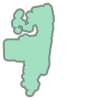

In [198]:
from shapely.geometry import MultiPolygon

# Assuming you have a GeoDataFrame called gdf with a 'geometry' column containing polygons

# Create a single polygon representing the outermost border
outer_polygon = final_buffer['geometry'].unary_union

# Check if the result is a MultiPolygon and convert it to a Polygon if necessary
if isinstance(outer_polygon, MultiPolygon):
    outer_polygon = outer_polygon.convex_hull

# Now you have a single polygon representing the outermost border
outer_polygon

In [199]:
# Create a new GeoDataFrame with the outer polygon
outer_gdf = gpd.GeoDataFrame(geometry=[outer_polygon])

# Set the coordinate reference system (CRS) if needed
# outer_gdf.crs = ...

# Export the GeoDataFrame to a GeoJSON file
outer_gdf.to_file('outer_polygon.geojson', driver='GeoJSON')